# TP Python Master IBM/RPM
## 1ère partie : introduction au langage Python
Février 2025

### Albertine Dubois - <span class="glyphicon glyphicon-envelope"></span> albertine.dubois@cea.fr et Marion Savanier - <span class="glyphicon glyphicon-envelope"></span> marion.savanier@universite-paris-saclay.fr


#Projet

Lors d'un protocole expérimental, dans le but de faire de la caractérisation tissulaire, nous avons fait des acquisitions sur un fantôme contenant $7$ tubes avec des $T2$ différents.

Nous avons acquis $6$ points de mesure en faisant varier le temps d'écho $TE$ de la séquence ($7\ ms$, $10\ ms$, $30\ ms$, $60\ ms$, $120\ ms$, $200\ ms$), le $TR$ utilisé est suffisamment long pour permettre la repousse complète en $T1$.

Vous souhaitez à présent traiter vos acquisitions. Le but de cet exercice est d&#39;estimer les $T2$ de chaque tube.

In [1]:
!git clone https://github.com/marsvn/PythonM2-jour1.git
!pip install SimpleITK

fatal: destination path 'PythonM2-jour1' already exists and is not an empty directory.


**Question 1.** Charger en utilisant la librairie SimpleITK les 6 fichiers image (S_TE_xxms.nii) correspondant aux 6 points de mesure et les concaténer pour avoir une matrice 3D : les deux premières dimensions correspondant aux dimensions de l'image et la troisième aux différentes valeurs de $TE$

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
PWD_DIR = os.getcwd()

In [3]:
S1 = sitk.GetArrayFromImage(sitk.ReadImage("/content/PythonM2-jour1/data/S_TE_7ms.nii"))
S2 = sitk.GetArrayFromImage(sitk.ReadImage("/content/PythonM2-jour1/data/S_TE_10ms.nii"))
S3 = sitk.GetArrayFromImage(sitk.ReadImage("/content/PythonM2-jour1/data/S_TE_30ms.nii"))
S4 = sitk.GetArrayFromImage(sitk.ReadImage("/content/PythonM2-jour1/data/S_TE_60ms.nii"))
S5 = sitk.GetArrayFromImage(sitk.ReadImage("/content/PythonM2-jour1/data/S_TE_120ms.nii"))
S6 = sitk.GetArrayFromImage(sitk.ReadImage("/content/PythonM2-jour1/data/S_TE_200ms.nii"))
Stot = np.dstack((S1,S2,S3,S4,S5,S6))
print(Stot.shape)

(512, 512, 6)


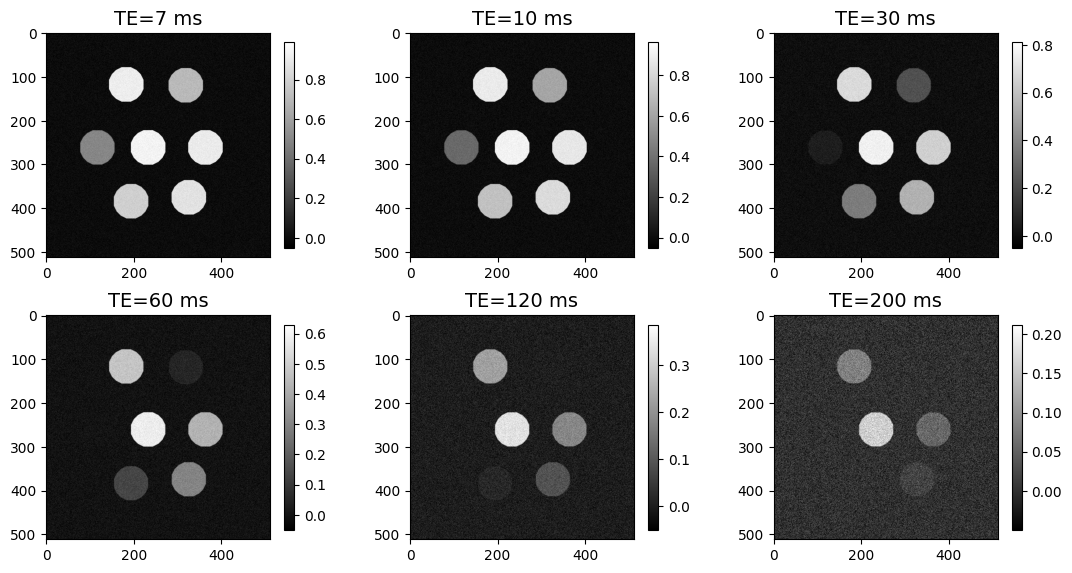

In [4]:
legends = ['TE=7 ms','TE=10 ms','TE=30 ms','TE=60 ms','TE=120 ms','TE=200 ms']
fig = plt.figure(figsize=(13,7))
fig.subplots_adjust(wspace=0.3, hspace=0.1)
for i in range(Stot.shape[2]):
    ax = fig.add_subplot(2,3,i+1)
    im = ax.imshow(Stot[:,:,i],cmap='gray')
    fig.colorbar(im,shrink=0.8)
    ax.set_title(legends[i], fontsize=14)

**Question 2.** Créer un vecteur `xdata` contenant les différents temps d&#39;écho

In [5]:
xdata = np.array([7,10,30,60,120,200])

**Question 3.** Ecrire la fonction de décroissance du signal $S(TE)=S_0\times exp(-t\times R2)$ avec $R2=\frac{1}{T2}$

In [6]:
from scipy import optimize
import time

x0 = np.array([0,0])

def model(x, u):
    return x[0]*np.exp(-u*x[1])

def fun(x, u, y):
    return model(x, u) - y

**Question 4.** Nous avons choisi de faire une approximation non-linéaire avec la fonction [least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) du module `optimize` de Scipy. Tester le traitement sur quelques pixels pour estimer le temps de calcul

In [7]:
T2_est1 = np.zeros((512,512))
S0_est1 = np.zeros((512,512))

#bounds=([0,0],[100,1])

t = time.time()

for i in range(512):
    for j in range(512):
        ydata = Stot[i,j,:].squeeze()
        #params, params_covariance = optimize.leastsq(fun, x0, ftol=1e-6, xtol=1e-6, args=(xdata, ydata))
        params = optimize.least_squares(fun, x0, method='lm', ftol=1e-6, xtol=1e-6, args=(xdata, ydata))
        T2_est1[i,j] = 1/params.x[1]
        S0_est1[i,j] = params.x[0]

elapsed = time.time() - t
print("Elapsed time is", elapsed, "seconds")

<ipython-input-7-c0dc3ce0f852>:13: RuntimeWarning: divide by zero encountered in scalar divide
  T2_est1[i,j] = 1/params.x[1]


Elapsed time is 288.5067529678345 seconds


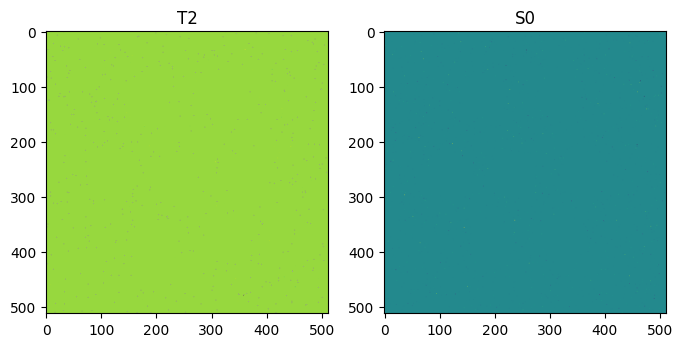

In [8]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.imshow(T2_est1)
plt.title('T2')
plt.subplot(122)
plt.imshow(S0_est1)
plt.title('S0')
output_file_name = '/content/PythonM2-jour1/output/test1.nii'
sitk.WriteImage(sitk.GetImageFromArray(T2_est1),output_file_name)

**Question 5.** Créer un masque sur les tubes

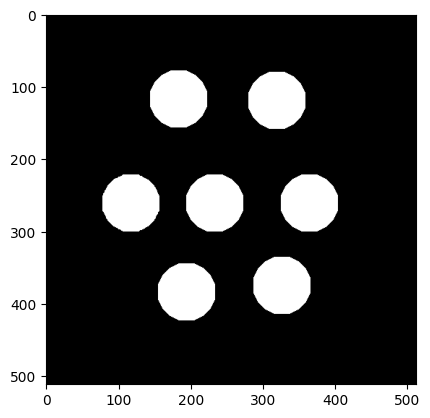

In [9]:
mask = S1 > 0.3
plt.imshow(mask,cmap='gray')

**Question 6.** Utiliser ce masque pour ajouter un test avant de d'exécuter la fonction `least_squares` et estimer le temps de calcul.

In [10]:
T2_est2 = np.zeros((512,512))
S0_est2 = np.zeros((512,512))

t = time.time()

for i in range(512):
    for j in range(512):
        if mask[i,j]==True:
            ydata = Stot[i,j,:].squeeze()
            #params, params_covariance = optimize.leastsq(fun, x0, ftol=1e-6, xtol=1e-6, args=(xdata, ydata))
            params = optimize.least_squares(fun, x0, method='lm', ftol=1e-6, xtol=1e-6, args=(xdata, ydata))
            T2_est2[i,j] = 1/params.x[1]
            S0_est2[i,j] = params.x[0]

elapsed = time.time() - t
print("Elapsed time is", elapsed, "seconds")

Elapsed time is 19.532179832458496 seconds


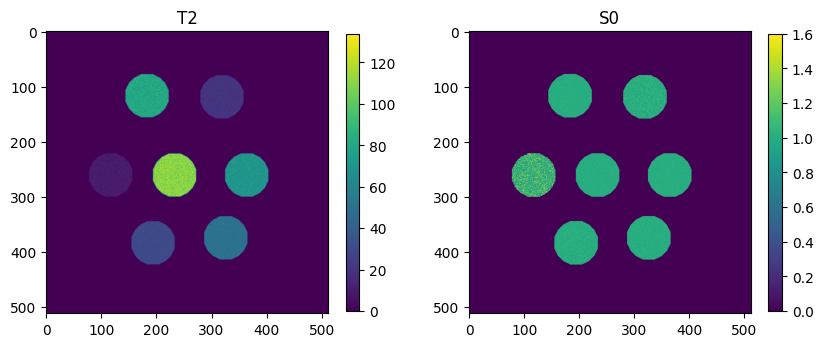

In [11]:
plt.subplots(1,2,figsize=(10,6))
plt.subplot(121)
plt.imshow(T2_est2)
plt.colorbar(shrink=0.6)
plt.title('T2')
plt.subplot(122)
plt.imshow(S0_est2,vmin=0,vmax=1.6)
plt.colorbar(shrink=0.6)
plt.title('S0')
output_file_name = '/content/PythonM2-jour1/output/test2.nii'
sitk.WriteImage(sitk.GetImageFromArray(S0_est2),output_file_name)

**Question 7.** Quelle stratégie pourriez-vous mettre en place pour réduire encore le temps de traitement ?

**Question 7.1.** Trouver les coordonnées des points à traiter

In [12]:
T2_est3 = np.zeros((512,512))
S0_est3 = np.zeros((512,512))

X, Y = np.meshgrid(np.arange(0,512),np.arange(0,512))
X = X*mask
Y = Y*mask
vec = np.array([Y[Y!=0],X[X!=0]])
vec = vec.transpose()
#print(vec)

In [13]:
t = time.time()

for i in range(vec.shape[0]):
    ydata = Stot[vec[i,0],vec[i,1],:].squeeze()
    #params, params_covariance = optimize.curve_fit(test_func, xdata, ydata, p0=[0,0],bounds=(0, [100., 1.]))
    params = optimize.least_squares(fun, x0, method='lm', ftol=1e-6, xtol=1e-6, args=(xdata, ydata))
    T2_est3[vec[i,0],vec[i,1]] = 1/params.x[1]
    S0_est3[vec[i,0],vec[i,1]] = params.x[0]

elapsed = time.time() - t
print("Elapsed time is", elapsed, "seconds")

Elapsed time is 20.29529094696045 seconds


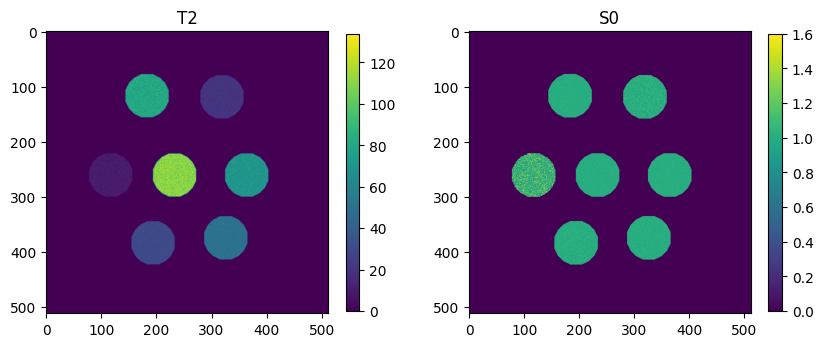

In [14]:
plt.subplots(1,2,figsize=(10,6))
plt.subplot(121)
plt.imshow(T2_est3)
plt.colorbar(shrink=0.6)
plt.title('T2')
plt.subplot(122)
plt.imshow(S0_est3,vmin=0,vmax=1.6)
plt.colorbar(shrink=0.6)
plt.title('S0')
output_file_name = '/content/PythonM2-jour1/output/test3.nii'
sitk.WriteImage(sitk.GetImageFromArray(T2_est3),output_file_name)

**Question 7.2.** Modifier la valeur de départ de $x_0$ en fonction des valeurs qui viennent d'être estimées.

In [15]:
T2_est4 = np.zeros((512,512))
S0_est4 = np.zeros((512,512))
t = time.time()

for i in range(vec.shape[0]):
    ydata = Stot[vec[i,0],vec[i,1],:].squeeze()
    params = optimize.least_squares(fun, x0, method='lm', ftol=1e-6, xtol=1e-6, args=(xdata, ydata))
    x0 = params.x
    T2_est4[vec[i,0],vec[i,1]] = 1/params.x[1]
    S0_est4[vec[i,0],vec[i,1]] = params.x[0]

elapsed = time.time() - t
print("Elapsed time is", elapsed, "seconds")

Elapsed time is 16.157888174057007 seconds


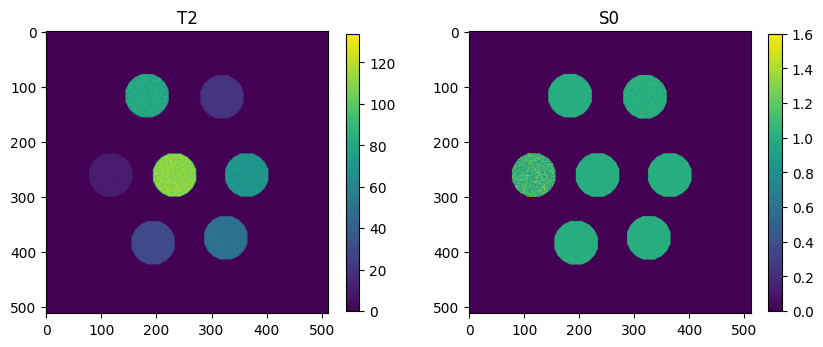

In [16]:
plt.subplots(1,2,figsize=(10,6))
plt.subplot(121)
plt.imshow(T2_est4)
plt.colorbar(shrink=0.6)
plt.title('T2')
plt.subplot(122)
plt.imshow(S0_est4,vmin=0,vmax=1.6)
plt.colorbar(shrink=0.6)
plt.title('S0')
output_file_name = '/content/PythonM2-jour1/output/test4.nii'
sitk.WriteImage(sitk.GetImageFromArray(T2_est4),output_file_name)

**Question 8.** Réutiliser le masque et la fonction `show_stats` pour obtenir la moyenne et l'écart-type des mesures de $T2$ pour chaque tube

In [17]:
from ipywidgets import interact, fixed

from scipy import ndimage
import pandas as pd


def show_stats(mask,img,file):
    # Identification des labels et calcul des volumes correspondants
    label_im, nb_labels = ndimage.label(mask)
    label_sizes=ndimage.sum(mask, label_im, range(1,nb_labels + 1))

    print("Nombre de régions :", nb_labels)

    # On stocke les résultats dans un dictionnaire
    stats_list={"Volume (nombre pixels)": label_sizes,
                "Valeur moyenne": ndimage.mean(img, label_im, range(1,nb_labels + 1)),
                "Ecart-type": ndimage.standard_deviation(img, label_im, range(1,nb_labels + 1)),
                "Valeur maximum": ndimage.maximum(img, label_im, range(1,nb_labels + 1)),
                "Valeur minimum": ndimage.minimum(img, label_im, range(1,nb_labels + 1)),
                "Valeur médiane": ndimage.median(img, label_im, range(1,nb_labels + 1)),
                }

    # On génère un Pandas dataframe à partir de ce dictionnaire
    stats=pd.DataFrame(stats_list, index=range(1,nb_labels + 1))
    # On enregistre le tout dans un fichier csv
    stats.to_csv(file, mode='a', sep='\t')
    return stats

In [18]:
interact(show_stats, mask=fixed(mask), img=fixed(T2_est2), file='/content/PythonM2-jour1/output/output.csv');

interactive(children=(Text(value='/content/PythonM2-jour1/output/output.csv', description='file'), Output()), …

In [19]:
interact(show_stats, mask=fixed(mask), img=fixed(T2_est3), file='/content/PythonM2-jour1/output/output.csv');

interactive(children=(Text(value='/content/PythonM2-jour1/output/output.csv', description='file'), Output()), …

In [20]:
interact(show_stats, mask=fixed(mask), img=fixed(T2_est4), file='/content/PythonM2-jour1/output/output.csv');

interactive(children=(Text(value='/content/PythonM2-jour1/output/output.csv', description='file'), Output()), …